# <center>TSA3</center>
## <div align='right'>Made by Ihor Markevych</div>

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.tsa.stattools as st
import statsmodels.graphics.tsaplots as statplots
import statsmodels.tsa.arima_model as arima

In [2]:
robberies = pd.read_csv('./robberies.csv', index_col=0)
x = [i for i in range(len(robberies))]
y = np.array(robberies).reshape(1,-1)[0]

## 1 Perform a complete Box-Jenkins analysis to arrive at what you believe to be the optimum ARIMA(p,d,q) model

### a. Plot the series. 

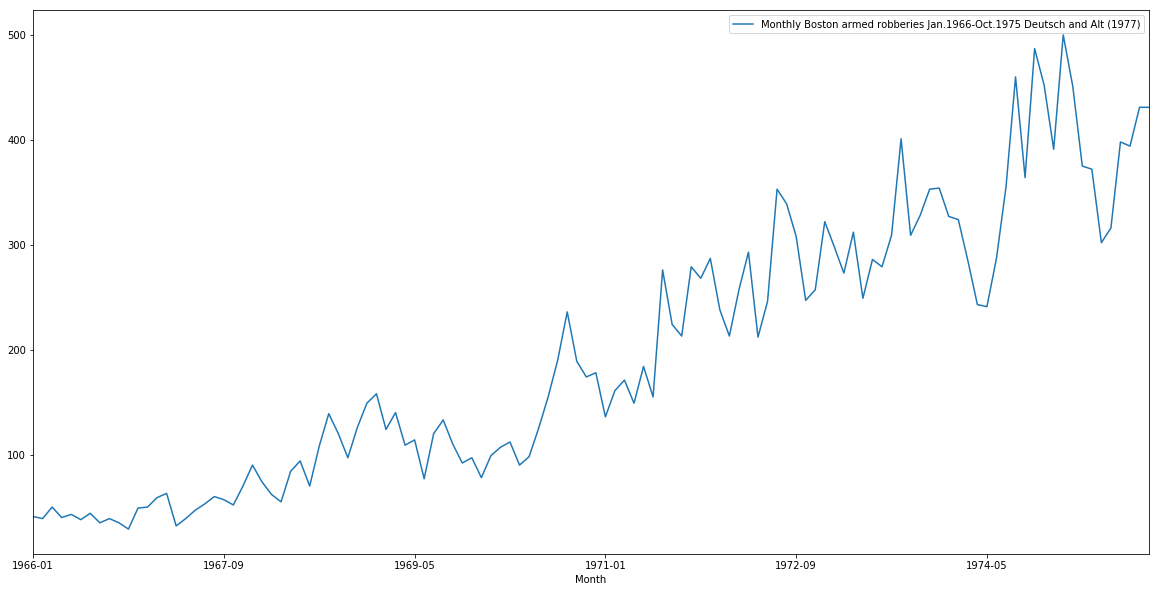

In [3]:
robberies.plot(figsize=(20,10))
plt.show()

### b. Perform a Dickey-Fuller test on the series. Is the series stationary?

In [4]:
def adfullerWithPrint(data):
    t = st.adfuller(data)
    print(f'ADF statistic \t\t {t[0]}.')
    print(f'p-value \t\t {t[1]}.')
    print(f'Critical values \t\t {t[4]}.')
    
adfullerWithPrint(y)

ADF statistic 		 1.0011021402457776.
p-value 		 0.994277563805723.
Critical values 		 {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}.


No, the series are not stationary.


### c. Plot the ACF & PACF and observe the trends.

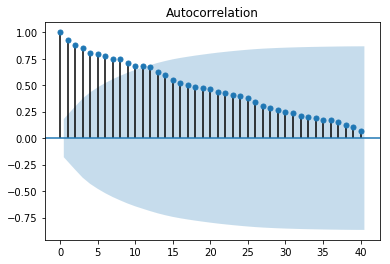

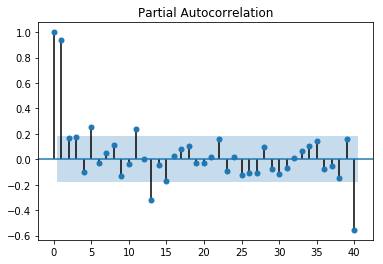

In [5]:
statplots.plot_acf(y, lags=40)
statplots.plot_pacf(y, lags=40)
plt.show()

We can see sinusoidal behaviour of ACF (more clear if we plot more lags).  
Both plots does not cut after several spikes.

### d. Perform differencing on the series. 

In [6]:
def trendDifferencing(y, k):
    if k == 1:
        return [y[i] - y[i - 1] for i in range(1, len(y))]
    
    return differencing(differencing(y, k - 1), 1)

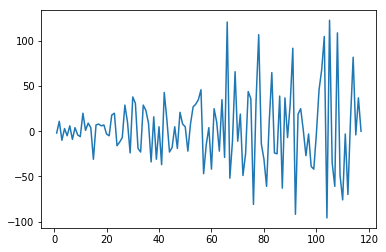

In [7]:
difY = trendDifferencing(y, 1)
plt.plot(x[1:], difY)
plt.show()

### e. Is the differenced series stationary?

In [8]:
adfullerWithPrint(difY)

ADF statistic 		 -7.428564475067208.
p-value 		 6.450795412686704e-11.
Critical values 		 {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}.


Yes, series with difference of order 1 is stationary.

### f. Plot the ACF & PACF of the differenced data and select the p & q orders

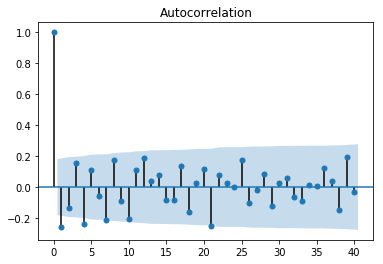

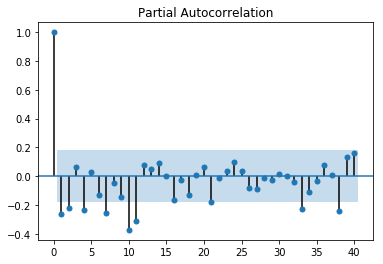

In [9]:
statplots.plot_acf(difY, lags=40)
statplots.plot_pacf(difY, lags=40)
plt.show()

We can see that pattern changed comparing to original data, especially in ACF - instead of slow decay (that continues with sinusoidal behaviour) ACF is cut sharply after first spike.  
  
ACF is cut after one spike.  
PACF is cut after two spikes.

**ARMA(2,1)**.

### g. Run an ARIMA analysis with the original series and the (p,d,q) you've deduced from above

In [10]:
model = arima.ARIMA(y, order=(2,1,1))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  117
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -592.107
Method:                       css-mle   S.D. of innovations             38.118
Date:                Sat, 07 Mar 2020   AIC                           1194.213
Time:                        13:06:06   BIC                           1208.024
Sample:                             1   HQIC                          1199.820
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2980      2.539      1.299      0.194      -1.679       8.275
ar.L1.D.y     -0.8811      0.168     -5.235      0.000      -1.211      -0.551
ar.L2.D.y     -0.3641      0.086     -4.243      0.000      -0.532      -0.196
ma.L1.D.y      0.6133      0.166      3.699      0.000       0.288       0.938
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2100           -1.1324j            1.6572           -0.3803
AR.2           -1.2100           +1.1324j            1.6572            0.3803
MA.1           -1.6305           +0.0000j            1.6305            0.5000
-----------------------------------------------------------------------------
"""

### h. Plot the residuals.

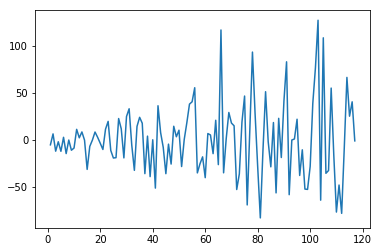

In [11]:
plt.plot(x[1:], model.resid)
plt.show()

### i. Plot the residual distribution (kind='kde').

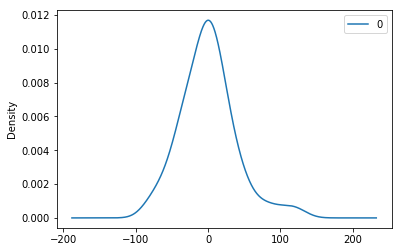

In [12]:
resid = pd.DataFrame(model.resid)
resid.plot(kind='kde')
plt.show()

### j. Print the residuals summary.

In [13]:
resid.describe()

,0
count,117.000000
mean,0.002930
std,38.282841
min,-83.077242
25%,-25.757245
50%,-0.239504
75%,18.435427
max,127.310482


### k. Plot the ACF & PACF and observe for residual correlations

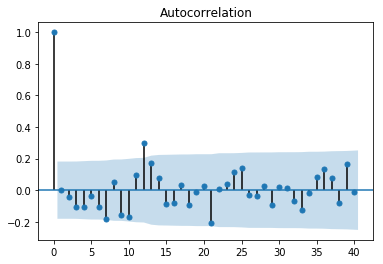

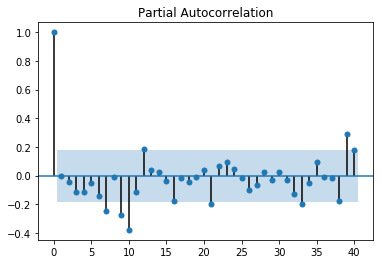

In [14]:
statplots.plot_acf(resid, lags=40)
statplots.plot_pacf(resid, lags=40)
plt.show()

Residuals look close to white noise.

### l. Compare the model results series to the actuals:


#### i Convert the residuals to the series estimated by ARIMA (hint: resids = y - yhat).

#### ii Add back the differencing to compare with the original series. 

In [15]:
preds = [y[0]]
preds += [y[i + 1] - float(resid.iloc[i]) for i in range(len(resid))]

#### iii Plot the actual and modeled results on the same graph.

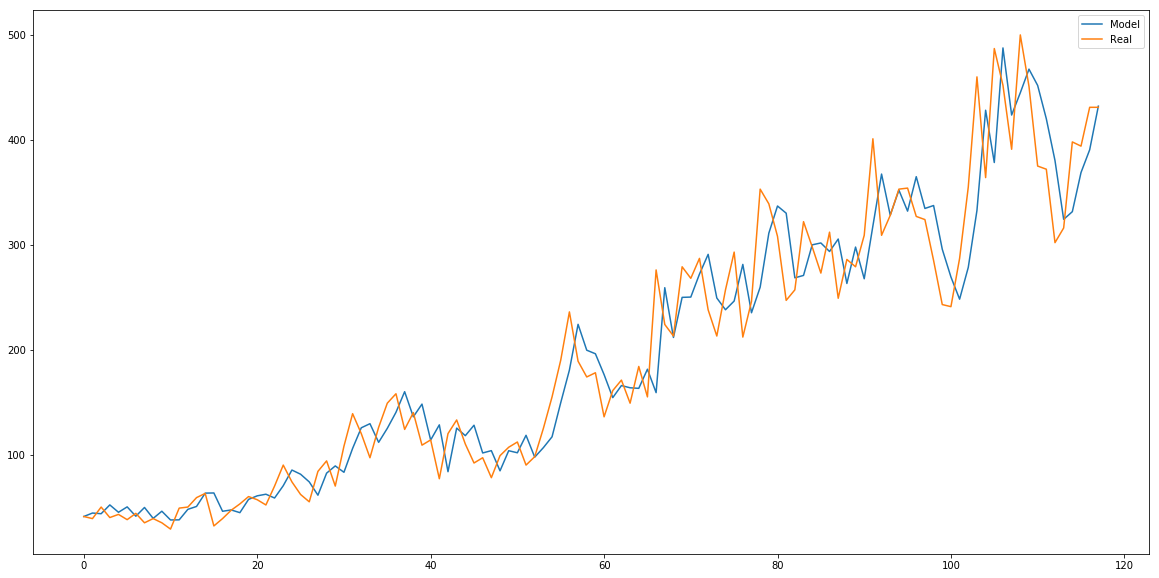

In [16]:
plt.figure(figsize=(20,10))
plt.plot(x, preds, label='Model')
plt.plot(x, y, label='Real')
plt.legend()
plt.show()

## 2 Create a AIC grid search and run 'robberies.csv' through it to find the optimum p,d,q order

In [17]:
pValues = range(7)
qValues = range(7)
dValues = range(3)

bestParams = None, None, None
bestScore = float('inf')
warnings.filterwarnings("ignore")

for p in pValues:
    for q in qValues:
        for d in dValues:
            try:
                tempModel = arima.ARIMA(y, (p, d, q))
                tempModel = tempModel.fit()
                if tempModel.aic < bestScore:
                    bestParams = p, d, q
                    bestScore = tempModel.aic
            except:
                ;

In [18]:
bestParams

(0, 2, 5)

In [19]:
bestScore

1182.0066039165847

### What is the optimum p,d,q order?

Optimal $(p, d, q)$ from $[0:6] \times [0:2] \times [0:6]$ is $(0, 2, 5)$.  
  
Note: this is for library version `0.11.0`, for `0.10.0` result should be (6,1,3).  

## 3 Compare the results of your orginal (p,d,q) estimate to the results from the grid search (p,d,q).

In [20]:
gridModel = arima.ARIMA(y, order=bestParams)
gridModel = gridModel.fit()

### Compare the residuals summaries

In [21]:
gridResid = pd.DataFrame(gridModel.resid)
gridResid.describe()

,0
count,116.000000
mean,1.892845
std,36.004660
min,-85.192669
25%,-17.350952
50%,1.053940
75%,18.270280
max,114.986647


Despite the lower AIC and smaller standart deviation values, mean is significantly further from 0.  
AIC is not much smaller from AIC of originally estimated model.  
We can also see that maximum value of residuals is smaller.

### Compare the graphs generated by the script made in 1.l above.

In [22]:
gridPreds = [y[0], y[1]]
gridPreds += [y[i + 2] - float(gridResid.iloc[i]) for i in range(len(gridResid))]

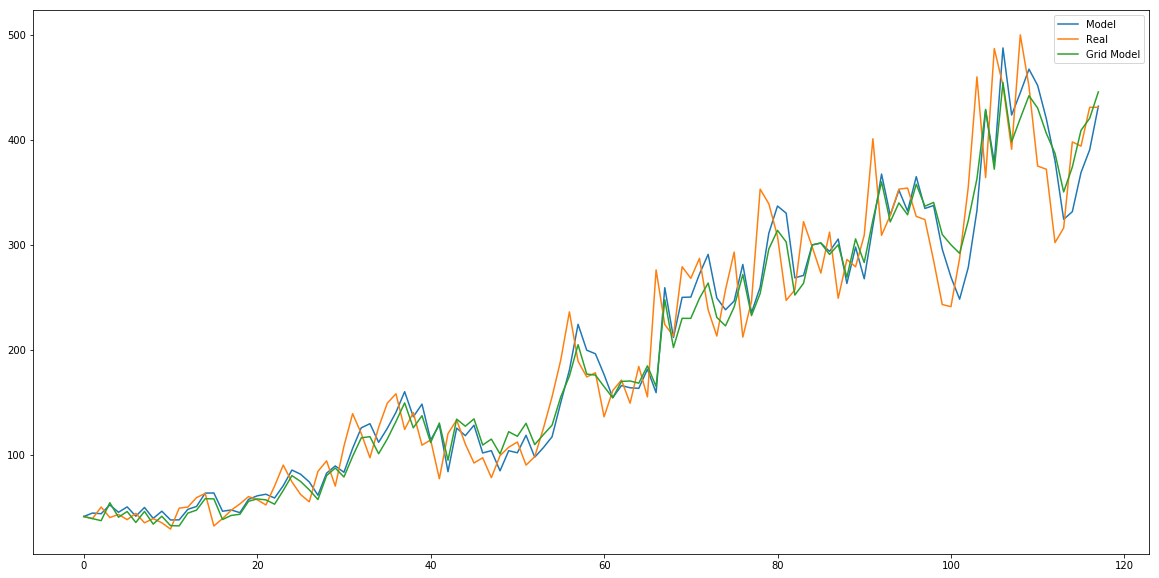

In [23]:
plt.figure(figsize=(20,10))
plt.plot(x, preds, label='Model')
plt.plot(x, y, label='Real')
plt.plot(x, gridPreds, label='Grid Model')
plt.legend()
plt.show()

We can observe that results of created models are very close to each other.

## 4 Forecast 'robberies.csv' based on an ARIMA(2,1,1) model:

### Split the series into 75% train, 25% test

In [24]:
yTrain = list(y[: int(len(y) * 0.75)])
yTest = list(y[int(len(y) * 0.75):])

### a. Perform a dynamic forecast for all points in 'test'


In [25]:
model = arima.ARIMA(yTrain, order=(2,1,1))
model = model.fit()
yPredictions, _, intervals = model.forecast(steps=len(yTest))

#### Plot the forecasted data and the prediction intervals on top of the actual data

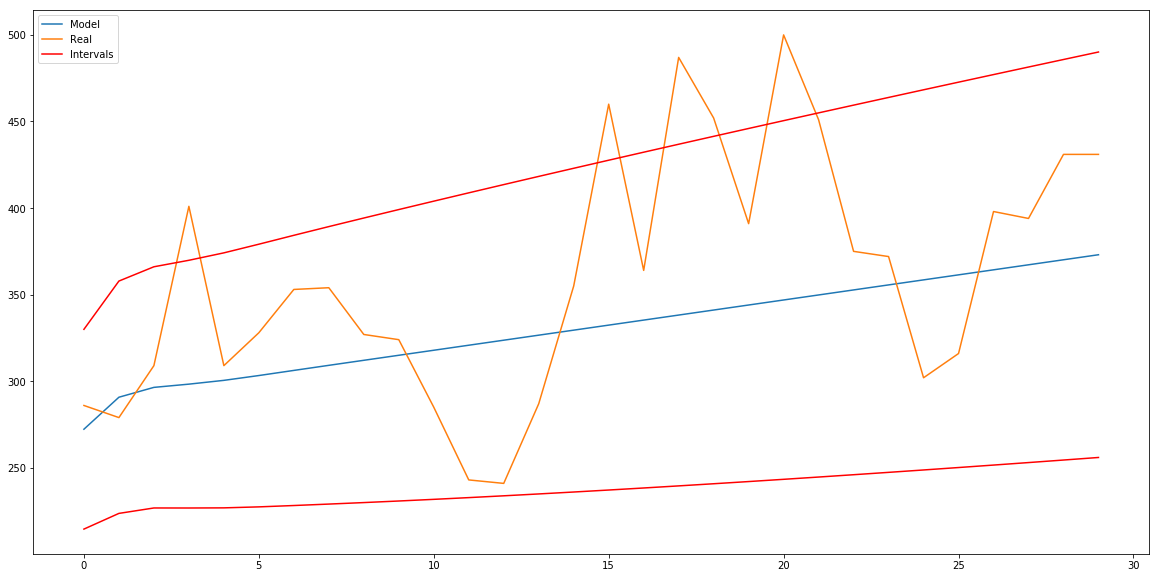

In [26]:
xTest = [i for i in range(len(yTest))]

plt.figure(figsize=(20,10))
plt.plot(xTest, yPredictions, label='Model')
plt.plot(xTest, yTest, label='Real')
plt.plot(xTest, np.array(intervals)[:,0], c='red', label='Intervals')
plt.plot(xTest, np.array(intervals)[:,1], c='red')
plt.legend()
plt.show()

### b. Perform a rolling forecast for all points in 'test'

In [27]:
yHistory = yTrain[:]

yPredictions = []
intervals = []

for i in range(len(yTest)):
    model = arima.ARIMA(yHistory, order=(2,1,1))
    model = model.fit()
    yHistory += [yTest[i]]
    yPredictions += [model.forecast()[0][0]]
    intervals += [list(model.forecast()[2][0])]

#### Plot the forecasted data and the prediction intervals on top of the actual data

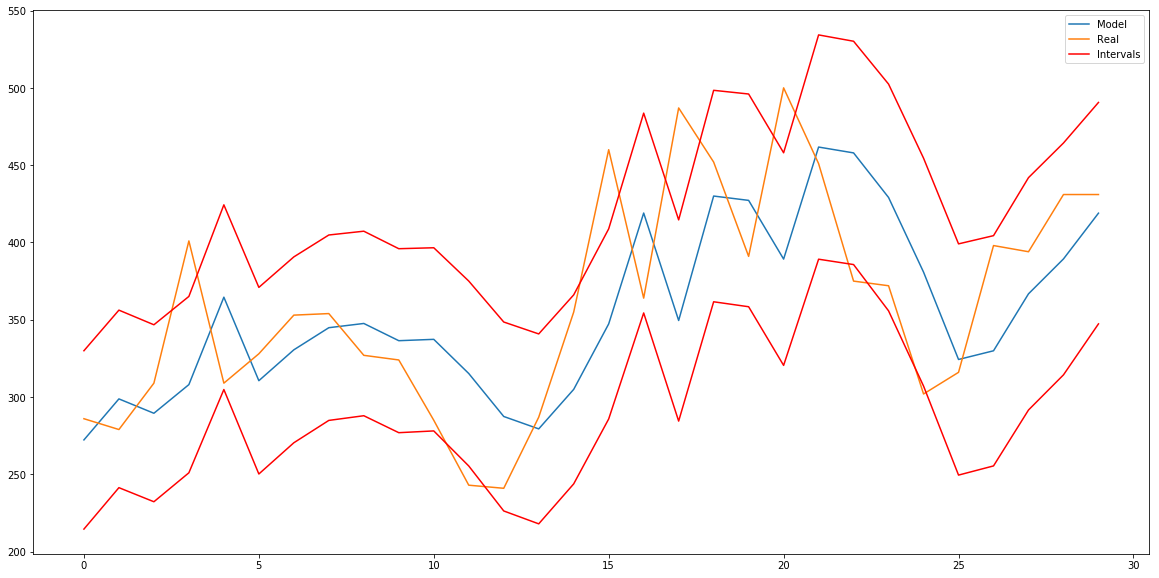

In [28]:
xTest = [i for i in range(len(yTest))]

plt.figure(figsize=(20,10))
plt.plot(xTest, yPredictions, label='Model')
plt.plot(xTest, yTest, label='Real')
plt.plot(xTest, np.array(intervals)[:,0], c='red', label='Intervals')
plt.plot(xTest, np.array(intervals)[:,1], c='red')
plt.legend()
plt.show()